In [32]:
import pyodbc
import pandas as pd
import numpy as np

conn = pyodbc.connect(
    "Driver={ODBC Driver 17 for SQL Server};"
    "Server=localhost;"  
    "Database=Olist;"
    "Trusted_Connection=yes;"
)

query = "SELECT * FROM dbo.Customer_RFM"
df = pd.read_sql(query, conn)
df.info()

C:\Users\lac23\AppData\Local\Temp\ipykernel_12896\1955353120.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93358 entries, 0 to 93357
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  93358 non-null  object 
 1   Recency             93358 non-null  int64  
 2   Frequency           93358 non-null  int64  
 3   Monetary            93358 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.8+ MB


In [33]:
RFM = df[['Recency','Frequency','Monetary']]
RFM_log = np.log1p(RFM)
RFM_log

,Recency,Frequency,Monetary
0,4.744932,0.693147,4.962145
1,4.770685,0.693147,3.338967
2,6.293419,0.693147,4.468434
3,5.783825,0.693147,3.798182
4,5.676754,0.693147,5.287711
...,...,...,...
93353,6.111467,0.693147,7.634540
93354,5.583496,0.693147,4.449452
93355,6.349139,0.693147,4.731450
93356,4.812184,0.693147,4.902976


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(RFM_log)
data_scaled = scaler.transform(RFM_log)
data_scaled = pd.DataFrame(data=data_scaled, index=RFM.index, columns=RFM.columns)
data_scaled

,Recency,Frequency,Monetary
0,-0.498209,-0.17019,0.288496
1,-0.469496,-0.17019,-1.719433
2,1.228297,-0.17019,-0.322243
3,0.660118,-0.17019,-1.151368
4,0.540737,-0.17019,0.691233
...,...,...,...
93353,1.025427,-0.17019,3.594345
93354,0.436759,-0.17019,-0.345724
93355,1.290422,-0.17019,0.003119
93356,-0.423226,-0.17019,0.215302


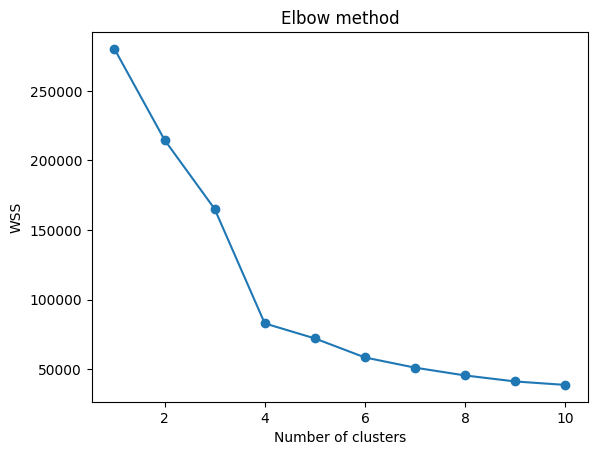

In [35]:
from sklearn.cluster import KMeans
WSS = []
for i in range (1,11):
    k_means = KMeans(n_clusters=i, random_state=0)
    k_means.fit(data_scaled)
    WSS.append(k_means.inertia_)

import matplotlib.pyplot as plt
plt.plot(range(1,11), WSS, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WSS')
plt.show()


In [36]:
kmeans = KMeans(n_clusters=4, random_state=5) 
labels = kmeans.fit_predict(data_scaled)

data_scaled['Cluster'] = labels
data_scaled.sort_values(by='Cluster', inplace=True)

In [37]:
grouped = data_scaled.groupby(['Cluster'])
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
  }).round(2)

Recency Frequency Monetary       
           mean      mean     mean  count
Cluster                                  
0          0.43     -0.17    -0.71  42029
1         -1.67     -0.17    -0.11  16994
2         -0.09      5.50     0.91   2801
3          0.34     -0.17     0.93  31534

In [38]:
cluster_names = {
    0: "One-time Low Value",      
    1: "One-time High Value",         
    2: "Loyal Premiums",   
    3: "Churned Customers"             
}
data_scaled['Cluster'] = data_scaled['Cluster'].map(cluster_names)
data_scaled


,Recency,Frequency,Monetary,Cluster
26,1.323076,-0.17019,-0.474646,One-time Low Value
24,0.007499,-0.17019,-0.728582,One-time Low Value
6,-0.319433,-0.17019,-1.403925,One-time Low Value
93354,0.436759,-0.17019,-0.345724,One-time Low Value
93355,1.290422,-0.17019,0.003119,One-time Low Value
...,...,...,...,...
7,0.037881,-0.17019,1.622687,Churned Customers
5,-0.201960,-0.17019,0.488525,Churned Customers
93356,-0.423226,-0.17019,0.215302,Churned Customers
4,0.540737,-0.17019,0.691233,Churned Customers


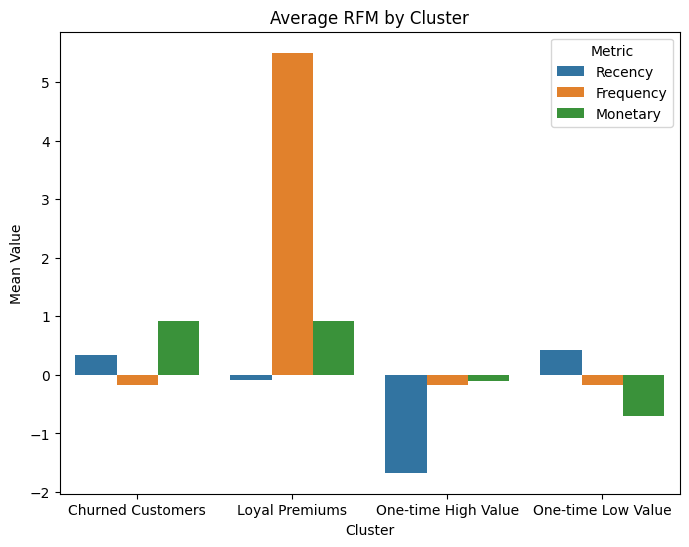

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

cluster_summary = data_scaled.groupby('Cluster')[["Recency","Frequency","Monetary"]].mean().reset_index()

plt.figure(figsize=(8,6))
cluster_summary_melted = cluster_summary.melt(id_vars="Cluster", var_name="Metric", value_name="Mean")

sns.barplot(x="Cluster", y="Mean", hue="Metric", data=cluster_summary_melted)

plt.title("Average RFM by Cluster")
plt.ylabel("Mean Value")
plt.xlabel("Cluster")
plt.legend(title="Metric")
plt.show()


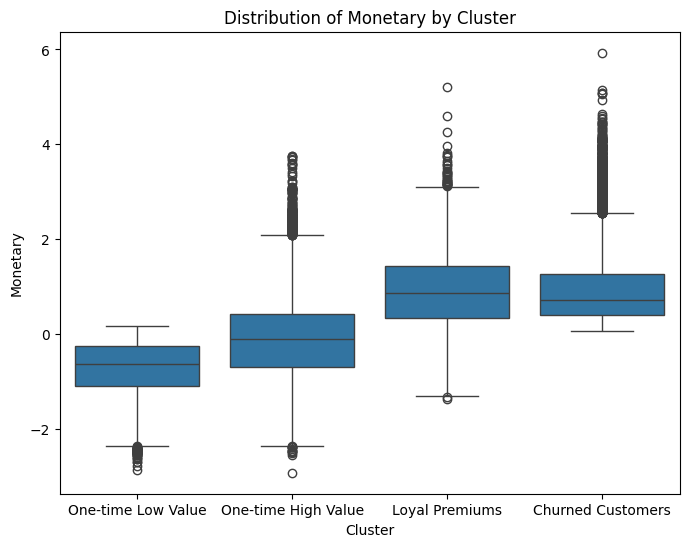

In [40]:
plt.figure(figsize=(8,6))
sns.boxplot(x="Cluster", y="Monetary", data=data_scaled)
plt.title("Distribution of Monetary by Cluster")
plt.show()

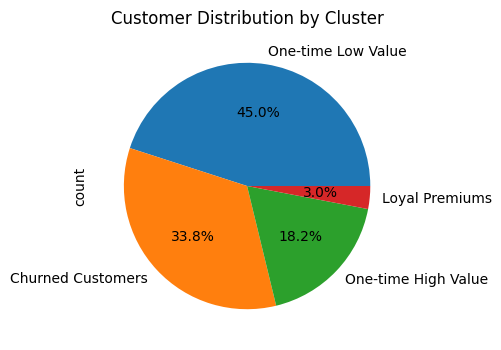

In [41]:
data_scaled["Cluster"].value_counts().plot(kind="pie", autopct='%1.1f%%', figsize=(4,4))
plt.title("Customer Distribution by Cluster")
plt.show()

In [ ]:
RFM = df[['Recency','Frequency','Monetary']]
RFM_log = np.log1p(RFM)
RFM_log
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(RFM_log)
data_scaled = scaler.transform(RFM_log)
data_scaled = pd.DataFrame(data=data_scaled, index=RFM.index, columns=RFM.columns)
data_scaled
kmeans = KMeans(n_clusters=4, random_state=5) 
labels = kmeans.fit_predict(data_scaled)

data_scaled['Cluster'] = labels


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. Chỉ lấy RFM để scale
rfm = df[['Recency', 'Frequency', 'Monetary']]

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# 2. Fit KMeans trên dữ liệu số
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(rfm_scaled)

# 3. Gắn nhãn tên cụm (mapping)
cluster_labels = {
    0: "One-time Low Value",
    1: "One-time High Value",
    2: "Loyal Premiums",
    3: "Churned Customers"
}
df['Cluster_Label'] = df['Cluster'].map(cluster_labels)

# 4. Xuất ra file với ID + RFM + Cluster
rfm_final = df[['customer_unique_id', 'Recency', 'Frequency', 'Monetary', 'Cluster', 'Cluster_Label']]
rfm_final.to_csv("RFM_clusters.csv", index=False, encoding='utf-8-sig')

print("✅ Xuất thành công RFM_clusters.csv")
